In [34]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [35]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

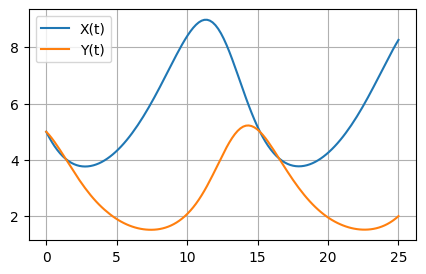

In [36]:
from scipy.integrate import solve_ivp

# We fix variables for clarity.
T = 25
alpha, beta, delta, gamma = 0.3, 0.1, 0.1, 0.6
x0, y0 = 5, 5

def lotka_volterra(t, u, alpha, beta, delta, gamma):
            x, y = u
            dx_dt = alpha * x - beta * x * y
            dy_dt = delta * x * y - gamma * y
            return [dx_dt, dy_dt]

t = torch.linspace(0, T, 128)
solution = solve_ivp(lotka_volterra, 
                        (0, T),
                        [x0, y0],
                        args=(alpha, beta, delta, gamma), 
                        t_eval=t)
x = solution.y[0]
y = solution.y[1]

fig = plt.figure(figsize=(5, 3))
plt.plot(t, x, label = 'X(t)')
plt.plot(t, y, label = 'Y(t)')
plt.grid()
plt.legend()
plt.show()

Our neural network for this task will have one input and two outputs.

In [37]:
from pinns import Domain
from pinns.samplers import ConstantSampler, RandomSampler

constraints_sampler = ConstantSampler((
    torch.tensor([[0.]]),
    torch.tensor([x0, y0])
))

domain = Domain({'t': [0, T]})
collocation_sampler = RandomSampler(domain, 2048, return_dict=False)

test_points_sampler = ConstantSampler((
    t.view(-1, 1), 
    torch.tensor([x, y]).T
    ))

In [38]:
from pinns.derivatives import Derivative

d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    ):
    
    def init_loss(u0, t0):
        return torch.mean(torch.square(u0 - cstr_vals))

    def ode_loss(u, t):
        x = u[:, [0]]
        y = u[:, [1]]
        
        dX = d(x, t)
        dY = d(y, t)
        
        LdX = torch.mean(torch.square(dX - alpha * x + beta * x * y))
        LdY = torch.mean(torch.square(dY - delta * x * y + gamma * y))
        
        return LdX, LdY
    
    return init_loss(cstr_pred, cstr_pts), *ode_loss(coll_pred, coll_pts)

In [39]:
ip_pts, ip_vals = test_points_sampler()
ip_pts.requires_grad_(True)

def residual(u, t):
    x = u[:, [0]]
    y = u[:, [1]]
    
    dX = d(x, t)
    dY = d(y, t)
    
    LdX = torch.square(dX - alpha * x + beta * x * y)
    LdY = torch.square(dY - delta * x * y + gamma * y)
    return (LdX + LdY) / 2

In [58]:
from pinns import Trainer
from pinns.models import FF
from pinns.activations import Sin
from pinns.optimizers import Adam
from pinns.analyze import InformationPropagation

pinn = FF([1] + [64]*2 + [2], activ=nn.Tanh(), biases=True)
print(f'Model has {pinn.count_parameters()} trainable parameters.')
init_params, _ = pinn.get_parameters_vector()

adam = Adam(pinn, lr = 1e-2)

ip = InformationPropagation(
    points = ip_pts, 
    values = ip_vals,
    domain = domain, 
    strategy = 'both',
    compute_every=1,
    residual = residual
)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2, 0.2],
    analyzers = [ip]
)

num_iters = 150

trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)]
    )
torch.save(pinn.model, './lv2500.pt')

Model has {'total': 4418, 'trainable': 4418} trainable parameters.


  0%|          | 0/150 [00:00<?, ?it/s]

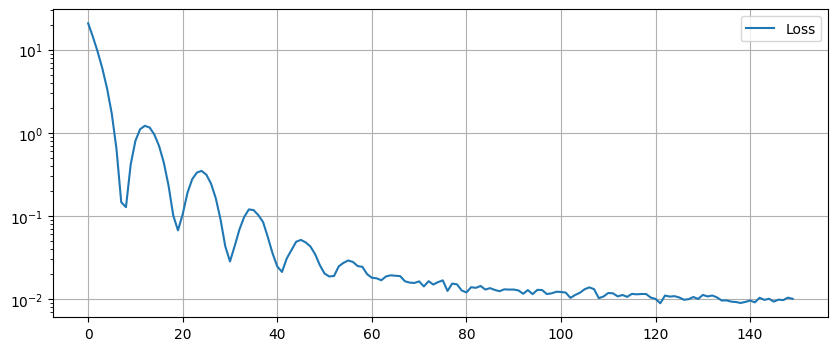

In [59]:
trainer.plot()

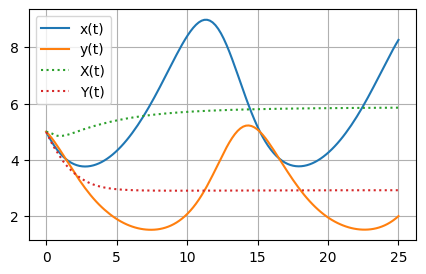

In [60]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig = plt.figure(figsize=(5, 3))

preds = pinn.predict(t.reshape(-1, 1))
plt.plot(t, x, label = 'x(t)')
plt.plot(t, y, label = 'y(t)')
plt.plot(t, preds[:,0].detach(), label='X(t)', linestyle=':')
plt.plot(t, preds[:,1].detach(), label='Y(t)', linestyle=':')
plt.grid()
plt.legend()

plt.show()

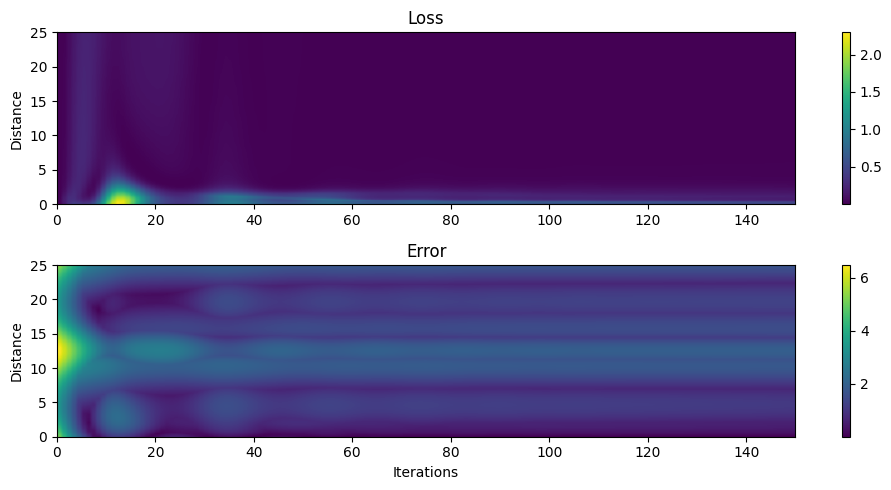

In [61]:
ip.plot(iterations=trainer.iter)

In [44]:
R = (pinn.get_parameters_vector()[0] - init_params).norm(p=2)

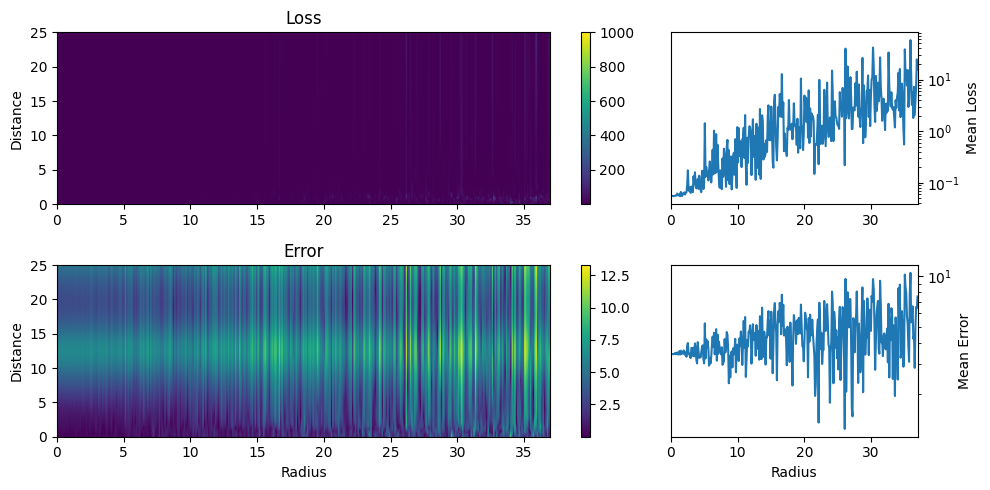

In [46]:
pinn.model = torch.load('./lv2500.pt')
ip.pplot(pinn, R = R * 5, num_points=350, loss_vmax = 1e3)